# MSPP Data Analysis Notebook

**Purpose**: Analyze mass spectrometry proteomics data from Orbitrap Astral MS (DIA-NN output)

## Notes

### Expected Results
- **HeLa**: log2 ratio ~0 (constant concentration, identical between E25 and E100)
- **E.coli**: log2 ratio ~-2 (25 fmol vs 100 fmol → log2(25/100) = -2)
- **Yeast**: log2 ratio ~+1 (150 fmol vs 75 fmol → log2(150/75) = 1)

### Sample Categorization Strategy
The notebook uses a two-tier approach to identify E25/E100 samples:
1. **Explicit Naming (Priority 1)**: Detects E25/E100/Y150/Y75 patterns in filenames
2. **E.coli Median Fallback**: If no patterns found, categorizes by E.coli median intensity
   - Lower half (lower E.coli) = E25/Y150 samples
   - Upper half (higher E.coli) = E100/Y75 samples

### Yeast Relationship
- **E25 ↔ Y150**: E25 samples are also Y150 (higher yeast spike-in)
- **E100 ↔ Y75**: E100 samples are also Y75 (lower yeast spike-in)

### Intensity Ratio Algorithm
The intensity ratio approach provides:
1. **Direct comparison** of E25 vs E100 replicates without normalization
2. **Technical variation assessment** - raw ratios preserve variability for QC
3. **Consensus proteins** - only proteins with valid intensity in BOTH samples
4. **Paired calculation** - log2(E25_intensity / E100_intensity) per protein

### Interpretation
- **HeLa ratios near 0**: Good technical reproducibility
- **E.coli ratios near -2**: Correct 4-fold spike-in maintained
- **Yeast ratios near +1**: Correct 2-fold spike-in maintained
- **Deviations from expected**: Indicate technical issues or sample preparation problems

### Workflow
- **Jupyter Notebook**: Development, validation, detailed analysis, QC checks
- **Web App**: Production tool for routine analysis with simplified interface

## 1. Import Libraries

**Required packages**:
- `pandas`: DataFrame manipulation and data analysis
- `numpy`: Numerical operations and array handling
- `matplotlib`: Plotting and visualization
- `re`: Regular expressions for pattern matching
- `pathlib`: Modern file path handling

In [4]:
import re
from pathlib import Path
from tkinter import filedialog

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure matplotlib
sns.set_style("darkgrid")
plt.rcParams['figure.facecolor'] = '#1e1e1e'
plt.rcParams['axes.facecolor'] = '#2d2d2d'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['legend.facecolor'] = '#2d2d2d'
plt.rcParams['legend.edgecolor'] = 'white'

print("✓ Imports complete")

✓ Imports complete


## 2. Define Organism Patterns

Set up regex patterns for identifying proteins from different organisms based on their UniProt ID format:
- **HeLa (human)**: Proteins with `_HUMAN` suffix
- **E.coli**: Proteins containing `ECOLI`
- **Yeast**: Proteins containing `YEAST`

In [5]:
# Define organism identification patterns
# HeLa: Proteins with _HUMAN suffix (e.g., GAL3A_HUMAN)
# E.coli: Proteins containing ECOLI
# Yeast: Proteins containing YEAST

hela_pattern = r"_HUMAN"
ecoli_pattern = r"ECOLI"
yeast_pattern = r"YEAST"

print("✓ Organism patterns defined:")
print(f"  HeLa: {hela_pattern}")
print(f"  E.coli: {ecoli_pattern}")
print(f"  Yeast: {yeast_pattern}")

✓ Organism patterns defined:
  HeLa: _HUMAN
  E.coli: ECOLI
  Yeast: YEAST


## 3. File Upload

**Instructions**: 
1. Run the cell below to open a file browser
2. Select your sample TSV files (hold Ctrl/Cmd to select multiple)
3. Files will be loaded into the notebook

**Sample Identification**:
- If filenames contain E25/E100/Y150/Y75 patterns, they will be automatically recognized
- Otherwise, samples will be auto-categorized using E.coli median intensity (see Section 7)

In [6]:
from tkinter import Tk

root = Tk()
root.withdraw()
root.attributes('-topmost', True)

print("Please select your TSV files (E25 and E100 samples)...")
file_paths = filedialog.askopenfilenames(
    title='Select TSV Files (you can select multiple)',
    filetypes=[('TSV files', '*.tsv'), ('Text files', '*.txt'), ('All files', '*.*')]
)

if len(file_paths) < 2:
    raise ValueError("Please select at least 2 files")

print(f"✓ Selected {len(file_paths)} file(s):")
for fp in file_paths:
    print(f"  - {Path(fp).name}")

# Store all files for processing
all_file_paths = list(file_paths)

Please select your TSV files (E25 and E100 samples)...
✓ Selected 38 file(s):
  - report.pg_matrix_0iQjUka.tsv
  - report.pg_matrix_1oSCzhJ.tsv
  - report.pg_matrix_8j4MIEK.tsv
  - report.pg_matrix_77uqPLK.tsv
  - report.pg_matrix_A3ns3Ke.tsv
  - report.pg_matrix_BCY6KtJ.tsv
  - report.pg_matrix_cDogd7T.tsv
  - report.pg_matrix_D8KURMh.tsv
  - report.pg_matrix_DifOMAJ.tsv
  - report.pg_matrix_doXw1Ma.tsv
  - report.pg_matrix_f3g48n5.tsv
  - report.pg_matrix_f8A1EXa.tsv
  - report.pg_matrix_FbFPnWU.tsv
  - report.pg_matrix_FUESXMi.tsv
  - report.pg_matrix_gHglff4.tsv
  - report.pg_matrix_Ibsqvau.tsv
  - report.pg_matrix_IfZlpsv.tsv
  - report.pg_matrix_ISVY05Y.tsv
  - report.pg_matrix_jE1sDfu.tsv
  - report.pg_matrix_kTRWK5g.tsv
  - report.pg_matrix_M2Zsklg.tsv
  - report.pg_matrix_Mzpn31E.tsv
  - report.pg_matrix_ob8RkrA.tsv
  - report.pg_matrix_p7IPROJ.tsv
  - report.pg_matrix_popryon.tsv
  - report.pg_matrix_q0fYkO6.tsv
  - report.pg_matrix_qDpoD5T.tsv
  - report.pg_matrix_rcjTldI.ts

## 4. Load and Process Data

Read all selected TSV files and prepare data for analysis:
1. Parse each file and detect intensity columns (containing `.raw` in column name)
2. Filter to keep only rows with positive intensity values
3. Identify organism for each protein based on protein name patterns
4. Concatenate all files into unified DataFrame with Source_File column

In [ ]:
def identify_organism_vectorized(protein_ids):
    organism = pd.Series("Unknown", index=protein_ids.index)
    organism[protein_ids.str.contains(hela_pattern, na=False)] = "HeLa"
    organism[protein_ids.str.contains(ecoli_pattern, na=False)] = "E.coli"
    organism[protein_ids.str.contains(yeast_pattern, na=False)] = "Yeast"
    return organism

all_data = []
file_to_raw_column = {}

# Use all selected files, not just the two hardcoded ones
files_to_load = all_file_paths if 'all_file_paths' in locals() else [e25_file_path, e100_file_path] # type: ignore

for file_path in files_to_load:
    print(f"\nLoading: {Path(file_path).name}")
    df = pd.read_csv(file_path, sep="\t")

    # Find intensity columns (columns containing .raw anywhere in the name)
    intensity_cols = [col for col in df.columns if '.raw' in col.lower()]

    # Map file stem to its raw column for later use
    file_stem = Path(file_path).stem
    file_to_raw_column[file_stem] = intensity_cols[0] if intensity_cols else None

    if not intensity_cols:
        print(f"  WARNING: No .raw columns found in {Path(file_path).name}")
        continue

    # Use the first raw column as the intensity column
    intensity_col = intensity_cols[0]

    # Convert intensity column to numeric and keep only positive values
    df["Intensity"] = pd.to_numeric(df[intensity_col], errors='coerce')
    df_filtered = df[df["Intensity"] > 0].copy()

    df_filtered["Source_File"] = file_stem

    # Find protein identifier column
    protein_col = next(
        (col for col in ["Protein.Names", "Protein.Group"] if col in df.columns),
        None
    ) or next((col for col in df.columns if "protein" in col.lower()), None)

    if protein_col:
        df_filtered["Organism"] = identify_organism_vectorized(df_filtered[protein_col])
    else:
        df_filtered["Organism"] = "Unknown"

    print(f"  ✓ {len(df_filtered):,} rows with positive intensity")
    all_data.append(df_filtered)

if all_data:
    data = pd.concat(all_data, ignore_index=True)
    print("\n✓ Data loaded successfully")
    print(f"Total rows: {len(data):,}")
    print(f"Source files: {sorted(data['Source_File'].unique())}")
    print("Organism distribution:")
    print(data['Organism'].value_counts())
else:
    print("ERROR: No data loaded. Check that files contain .raw columns")


Loading: report.pg_matrix_0iQjUka.tsv
  ✓ 10,511 rows with positive intensity

Loading: report.pg_matrix_1oSCzhJ.tsv
  ✓ 10,004 rows with positive intensity

Loading: report.pg_matrix_8j4MIEK.tsv
  ✓ 10,321 rows with positive intensity

Loading: report.pg_matrix_77uqPLK.tsv
  ✓ 10,485 rows with positive intensity

Loading: report.pg_matrix_A3ns3Ke.tsv
  ✓ 9,894 rows with positive intensity

Loading: report.pg_matrix_BCY6KtJ.tsv
  ✓ 9,999 rows with positive intensity

Loading: report.pg_matrix_cDogd7T.tsv
  ✓ 9,511 rows with positive intensity

Loading: report.pg_matrix_D8KURMh.tsv
  ✓ 10,485 rows with positive intensity

Loading: report.pg_matrix_A3ns3Ke.tsv
  ✓ 9,894 rows with positive intensity

Loading: report.pg_matrix_BCY6KtJ.tsv
  ✓ 9,999 rows with positive intensity

Loading: report.pg_matrix_cDogd7T.tsv
  ✓ 9,511 rows with positive intensity

Loading: report.pg_matrix_D8KURMh.tsv
  ✓ 11,140 rows with positive intensity

Loading: report.pg_matrix_DifOMAJ.tsv
  ✓ 9,837 rows with

## 5. Data Overview

Quick look at the loaded data structure and organism distribution across samples.

In [8]:
print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)
print(f"\nDataFrame shape: {data.shape}")
print("\nOrganism Distribution:")
organism_counts = data['Organism'].value_counts()
print(organism_counts)
print(f"Total: {organism_counts.sum():,}")

print("\nBy Sample:")
sample_org_counts = data.groupby(['Source_File', 'Organism']).size().unstack(fill_value=0)
display(sample_org_counts) # type: ignore

DATA OVERVIEW

DataFrame shape: (381976, 47)

Organism Distribution:
Organism
HeLa       221543
Yeast      136446
E.coli      23425
Unknown       562
Name: count, dtype: int64
Total: 381,976

By Sample:


Organism,E.coli,HeLa,Unknown,Yeast
Source_File,,,,
report.pg_matrix_0iQjUka,853,6145,18,3495
report.pg_matrix_1oSCzhJ,811,5880,20,3293
report.pg_matrix_77uqPLK,857,6156,15,3457
report.pg_matrix_8j4MIEK,821,6059,14,3427
report.pg_matrix_A3ns3Ke,366,5662,16,3850
report.pg_matrix_BCY6KtJ,811,5889,14,3285
report.pg_matrix_D8KURMh,950,6520,18,3652
report.pg_matrix_DifOMAJ,356,5602,16,3863
report.pg_matrix_FUESXMi,866,6280,15,3488


## 6. Define Analysis Utilities

Define helper functions:
- `extract_mix_identifier()`: Parse filename to extract experimental run parameters
- `calculate_intensity_ratios()`: Calculate log2(E25/E100) ratios for consensus proteins present in both E25 and E100 samples

In [9]:
def extract_mix_identifier(sample_name):
    """Extract mix identifier from filename (e.g., '30_4_440960_600')"""
    match = re.search(r"_(\d+)_(\d+)_(\d+)_(\d+)", sample_name)
    return f"{match.group(1)}_{match.group(2)}_{match.group(3)}_{match.group(4)}" if match else "Unknown"

def calculate_intensity_ratios(data, e25_file, e100_file, organism, file_to_raw_column):
    """Calculate log2(E25/E100) intensity ratios for consensus proteins"""
    if e25_file not in file_to_raw_column or e100_file not in file_to_raw_column:
        return None

    e25_intensity_col = file_to_raw_column[e25_file]
    e100_intensity_col = file_to_raw_column[e100_file]

    e25_data = data[data["Source_File"] == e25_file].copy()
    e100_data = data[data["Source_File"] == e100_file].copy()

    e25_org = e25_data[e25_data["Organism"] == organism]
    e100_org = e100_data[e100_data["Organism"] == organism]

    if len(e25_org) == 0 or len(e100_org) == 0:
        return None

    protein_col = next(
        (col for col in ["Protein.Group", "Protein.Ids", "Protein.Names"] if col in e25_org.columns),
        None
    )

    if protein_col is None:
        return None

    e25_valid = e25_org[
        (e25_org[e25_intensity_col].notna()) &
        (e25_org[e25_intensity_col] > 0)
    ]
    e100_valid = e100_org[
        (e100_org[e100_intensity_col].notna()) &
        (e100_org[e100_intensity_col] > 0)
    ]

    e25_proteins = set(e25_valid[protein_col])
    e100_proteins = set(e100_valid[protein_col])
    consensus_proteins = e25_proteins & e100_proteins

    print(f"  {organism}: E25={len(e25_proteins)}, E100={len(e100_proteins)}, consensus={len(consensus_proteins)}")

    if len(consensus_proteins) == 0:
        return None

    e25_consensus = e25_valid[e25_valid[protein_col].isin(consensus_proteins)].set_index(protein_col)
    e100_consensus = e100_valid[e100_valid[protein_col].isin(consensus_proteins)].set_index(protein_col)

    common_proteins = e25_consensus.index.intersection(e100_consensus.index)
    e25_aligned = e25_consensus.loc[common_proteins, e25_intensity_col]
    e100_aligned = e100_consensus.loc[common_proteins, e100_intensity_col]

    ratios = np.log2(e25_aligned.values / e100_aligned.values)
    valid_ratios = ratios[np.isfinite(ratios)]

    return valid_ratios if len(valid_ratios) > 0 else None

print("✓ Analysis utilities defined")

✓ Analysis utilities defined


## 7. Calculate Intensity Ratios

Identify E25/E100 pairs using hybrid categorization strategy:
1. **First**: Try to detect E25/E100/Y150/Y75 from filename patterns
2. **Fallback**: If not found, use E.coli median intensity to categorize samples
   - Lower E.coli median → E25/Y150 group
   - Higher E.coli median → E100/Y75 group

Then calculate log2 intensity ratios for each pair and organism.

In [10]:
# Get all sample files
sample_files = sorted(data["Source_File"].unique())

if len(sample_files) == 0:
    raise ValueError("No sample files found in data")

if len(sample_files) < 2:
    raise ValueError("Need at least 2 samples to create E25/E100 comparisons")

# Strategy 1: Try to detect E25/E100 from filenames (explicit naming)
e25_samples_explicit = []
e100_samples_explicit = []
unclassified_samples = []

for source_file in sample_files:
    upper = source_file.upper()
    # Check for E25 or Y150 patterns (same samples)
    if re.search(r'E[-_]?25|Y[-_]?150', upper):
        e25_samples_explicit.append(source_file)
    # Check for E100 or Y75 patterns (same samples)
    elif re.search(r'E[-_]?100|Y[-_]?75', upper):
        e100_samples_explicit.append(source_file)
    else:
        unclassified_samples.append(source_file)

# If we found explicit naming for all samples, use it
if len(e25_samples_explicit) > 0 and len(e100_samples_explicit) > 0 and len(unclassified_samples) == 0:
    e25_samples = sorted(e25_samples_explicit)
    e100_samples = sorted(e100_samples_explicit)
    categorization_method = "explicit naming (E25/E100/Y150/Y75)"
    print(f"✓ Using explicit sample naming: E25/Y150={[Path(s).stem for s in e25_samples]}, "
          f"E100/Y75={[Path(s).stem for s in e100_samples]}")
else:
    # Strategy 2: Fallback to automatic categorization using E.coli median
    print("No explicit E25/E100 naming found. Using E.coli median-based categorization.")
    categorization_method = "E.coli median auto-detection"

    # Calculate median E.coli intensity for each sample
    ecoli_medians = {}
    for source_file in sample_files:
        if source_file not in file_to_raw_column:
            continue

        intensity_col = file_to_raw_column[source_file]
        sample_data = data[data["Source_File"] == source_file].copy()
        ecoli_data = sample_data[sample_data["Organism"] == "E.coli"]

        if len(ecoli_data) > 0:
            ecoli_data_valid = ecoli_data[
                (ecoli_data[intensity_col].notna()) &
                (ecoli_data[intensity_col] > 0)
            ]
            if len(ecoli_data_valid) > 0:
                median_intensity = ecoli_data_valid[intensity_col].median()
                ecoli_medians[source_file] = median_intensity
                print(f"  {Path(source_file).stem}: E.coli median = {median_intensity:.2e}")

    if len(ecoli_medians) < 2:
        raise ValueError("Need at least 2 samples with E.coli data for auto-categorization")

    # Sort samples by E.coli median intensity
    sorted_samples = sorted(ecoli_medians.keys(), key=lambda x: ecoli_medians[x])

    # Split into E25 (lower half) and E100 (upper half) groups
    n_samples = len(sorted_samples)
    split_point = n_samples // 2

    e25_samples = sorted_samples[:split_point] if split_point > 0 else []
    e100_samples = sorted_samples[split_point:]

    if len(e25_samples) == 0 or len(e100_samples) == 0:
        raise ValueError("Could not split samples into E25/E100 groups")

    print(f"✓ Auto-categorized samples: E25/Y150={[Path(s).stem for s in e25_samples]}, "
          f"E100/Y75={[Path(s).stem for s in e100_samples]}")

# Pair E25 with E100 samples
sample_pairs = []
for i in range(min(len(e25_samples), len(e100_samples))):
    e25_sample = e25_samples[i]
    e100_sample = e100_samples[i]
    sample_pairs.append((e25_sample, e100_sample))

# Calculate intensity ratios for each organism and sample pair
ORGANISMS = ["HeLa", "E.coli", "Yeast"]
hela_results, ecoli_results, yeast_results = [], [], []

print(f"\nProcessing {len(sample_pairs)} sample pair(s) using {categorization_method}:\n")
for e25_sample, e100_sample in sample_pairs:
    # Create label based on categorization method
    e25_name = Path(e25_sample).stem
    e100_name = Path(e100_sample).stem

    # Only create labels if using explicit naming
    if categorization_method == "explicit naming (E25/E100/Y150/Y75)":
        pair_label = f"{e25_name} vs {e100_name}"
    else:
        pair_label = f"{e25_name} vs {e100_name}"

    print(f"Processing pair: {pair_label}")
    for organism in ORGANISMS:
        ratios = calculate_intensity_ratios(data, e25_sample, e100_sample, organism, file_to_raw_column)
        if ratios is not None:
            if organism == "HeLa":
                hela_results.append((ratios, pair_label))
            elif organism == "E.coli":
                ecoli_results.append((ratios, pair_label))
            elif organism == "Yeast":
                yeast_results.append((ratios, pair_label))

print(f"\n✓ Calculated ratios for {len(sample_pairs)} pair(s)")

No explicit E25/E100 naming found. Using E.coli median-based categorization.
  report: E.coli median = 7.85e+05
  report: E.coli median = 5.06e+05
  report: E.coli median = 5.08e+05
  report: E.coli median = 7.14e+05
  report: E.coli median = 4.35e+05
  report: E.coli median = 6.03e+05
  report: E.coli median = 6.48e+05
  report: E.coli median = 5.62e+05
  report: E.coli median = 5.10e+05
  report: E.coli median = 7.14e+05
  report: E.coli median = 4.35e+05
  report: E.coli median = 6.03e+05
  report: E.coli median = 6.48e+05
  report: E.coli median = 5.62e+05
  report: E.coli median = 5.10e+05
  report: E.coli median = 4.06e+05
  report: E.coli median = 8.04e+05
  report: E.coli median = 5.74e+05
  report: E.coli median = 6.05e+05
  report: E.coli median = 7.60e+05
  report: E.coli median = 4.06e+05
  report: E.coli median = 8.04e+05
  report: E.coli median = 5.74e+05
  report: E.coli median = 6.05e+05
  report: E.coli median = 7.60e+05
  report: E.coli median = 4.84e+05
  report: E.c

## 8. Protein Count Bar Chart

Create stacked bar chart showing organism composition across samples.

Protein ID Counts by Sample:
Organism                  HeLa  E.coli  Yeast  Unknown
Source_File                                           
report.pg_matrix_0iQjUka  6145     853   3495       18
report.pg_matrix_1oSCzhJ  5880     811   3293       20
report.pg_matrix_77uqPLK  6156     857   3457       15
report.pg_matrix_8j4MIEK  6059     821   3427       14
report.pg_matrix_A3ns3Ke  5662     366   3850       16
report.pg_matrix_BCY6KtJ  5889     811   3285       14
report.pg_matrix_D8KURMh  6520     950   3652       18
report.pg_matrix_DifOMAJ  5602     356   3863       16
report.pg_matrix_FUESXMi  6280     866   3488       15
report.pg_matrix_FbFPnWU  5080     301   3592        9
report.pg_matrix_ISVY05Y  6280     885   3498       17
report.pg_matrix_Ibsqvau  5982     422   3996       12
report.pg_matrix_IfZlpsv  5688     789   3189       13
report.pg_matrix_M2Zsklg  6358     891   3579       15
report.pg_matrix_Mzpn31E  6040     866   3366       20
report.pg_matrix_RpNXc33  5825     3

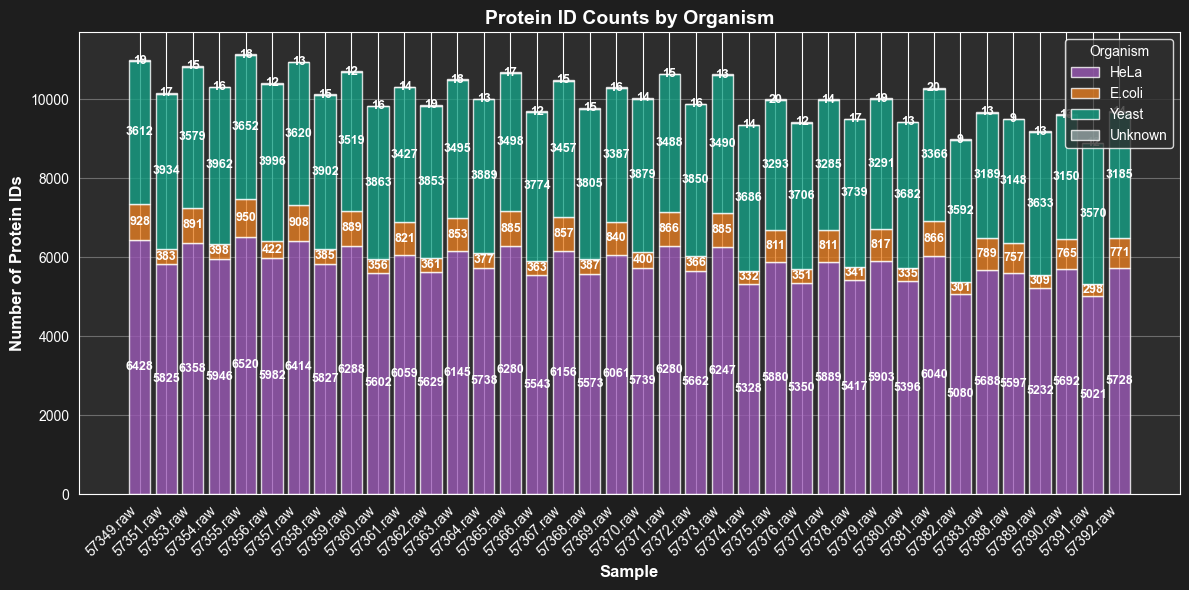

In [11]:
ORGANISMS = ["HeLa", "E.coli", "Yeast"]
COLORS = {"HeLa": "#9b59b6", "E.coli": "#e67e22", "Yeast": "#16a085", "Unknown": "#95a5a6"}

counts = data.groupby(["Source_File", "Organism"]).size().unstack(fill_value=0)
org_order = ORGANISMS + ["Unknown"]
counts = counts.reindex(
    columns=[col for col in org_order if col in counts.columns], fill_value=0
)

print("Protein ID Counts by Sample:")
print(counts)
print()

# Sort samples by numeric value extracted from .raw filename
def get_numeric_value(sample_name):
    """Extract numeric value from a single .raw filename for sorting."""
    raw_col = file_to_raw_column.get(sample_name, sample_name)
    raw_filename = Path(raw_col).stem if raw_col else sample_name
    # Extract first number found in filename (e.g., "57367" from "57367.raw")
    match = re.search(r'(\d+)', raw_filename)
    return int(match.group(1)) if match else 0

# Create sorted list of sample names, then reindex
sorted_samples = sorted(counts.index, key=get_numeric_value)
counts = counts.reindex(sorted_samples)

fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(counts))
for organism in counts.columns:
    ax.bar(
        range(len(counts)), counts[organism], bottom=bottom,
        label=organism, color=COLORS.get(organism, "#95a5a6"), alpha=0.8
    )
    bottom += counts[organism].values

for i, sample in enumerate(counts.index):
    y_offset = 0
    for organism in counts.columns:
        count = counts.loc[sample, organism]
        if count > 0:
            bar_height = count
            y_pos = y_offset + bar_height / 2

            ax.text(
                i, y_pos, str(int(count)),
                ha='center', va='center',
                fontsize=9, fontweight='bold',
                color='white'
            )
            y_offset += bar_height

# Get the .raw column names for x-axis labels
x_labels = []
for sample in counts.index:
    # Get the corresponding .raw column name, or use the sample name if not found
    raw_col = file_to_raw_column.get(sample, sample)
    # Extract just the filename from the full path (e.g., "57367.raw" from "D:\QC_DIA\57367.raw")
    raw_filename = Path(raw_col).name if raw_col else sample
    x_labels.append(raw_filename)

ax.set_xlabel("Sample", fontsize=12, fontweight="bold")
ax.set_ylabel("Number of Protein IDs", fontsize=12, fontweight="bold")
ax.set_title("Protein ID Counts by Organism", fontsize=14, fontweight="bold")
ax.legend(title="Organism", fontsize=10, loc="upper right")
ax.grid(axis="y", alpha=0.3)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(x_labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 9. Plotting Function for Ratio Comparison

Define function to create box plots showing log2 intensity ratio distributions for each organism and experimental run. Box plots display:
- Quartiles (box)
- Median (line inside box)
- Mean (white square marker)
- Whiskers extending to min/max values
- Individual outliers as data points

In [12]:
def plot_ratio_comparison(ax, results, title, color, reference_line):
    """Plot box plots for intensity ratios.

    Args:
        ax: Matplotlib axis
        results: List of (ratio_array, label) tuples
        title: Plot title
        color: Box plot color
        reference_line: Y-value for expected ratio reference line
    """
    data_arrays = [r[0] for r in results]
    mix_labels = [r[1] for r in results]
    positions = np.arange(1, len(data_arrays) + 1)

    bp = ax.boxplot(
        data_arrays,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        showfliers=True,
        showmeans=True,
        flierprops={
            "marker": "o", "markerfacecolor": color, "markersize": 3,
            "alpha": 0.4, "markeredgecolor": "none"
        },
        meanprops={
            "marker": "s", "markerfacecolor": "white",
            "markeredgecolor": "white", "markersize": 5
        },
    )

    for patch in bp["boxes"]:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor("white")
        patch.set_linewidth(1.5)

    plt.setp(bp["whiskers"], color="white", linewidth=1.5)
    plt.setp(bp["caps"], color="white", linewidth=1.5)
    plt.setp(bp["medians"], color="#2c3e50", linewidth=2.5)

    for i, data_arr in enumerate(data_arrays):
        median_val = np.median(data_arr)
        ax.text(
            i + 1, median_val, f"{median_val:.2f}",
            fontsize=9, va="bottom", ha="center", color="white",
            fontweight="bold",
            bbox={"boxstyle": "round,pad=0.3",
                     "facecolor": "black", "alpha": 0.5, "edgecolor": "none"}
        )

    ax.axhline(y=reference_line, color="#f39c12", linestyle="--",
               linewidth=2, alpha=0.9,
               label=f"Expected: {reference_line}")

    ax.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks(positions)
    ax.set_xticklabels(mix_labels, rotation=45, ha="right", fontsize=9)
    ax.grid(axis="y", alpha=0.3)
    ax.legend(fontsize=9, loc="upper right")

print("✓ Plotting function defined")

✓ Plotting function defined


## 10. Generate Intensity Ratio Plots

Create 3-panel stacked visualization showing log2 intensity ratios for each organism:
- **Top**: HeLa (expected ratio ≈ 0 - constant concentration)
- **Middle**: E.coli (expected ratio ≈ -2 - log2(25/100))
- **Bottom**: Yeast (expected ratio ≈ +1 - log2(150/75))

Each panel shows box plot distribution of protein ratios with individual data points shown as outliers and expected value marked with reference line.

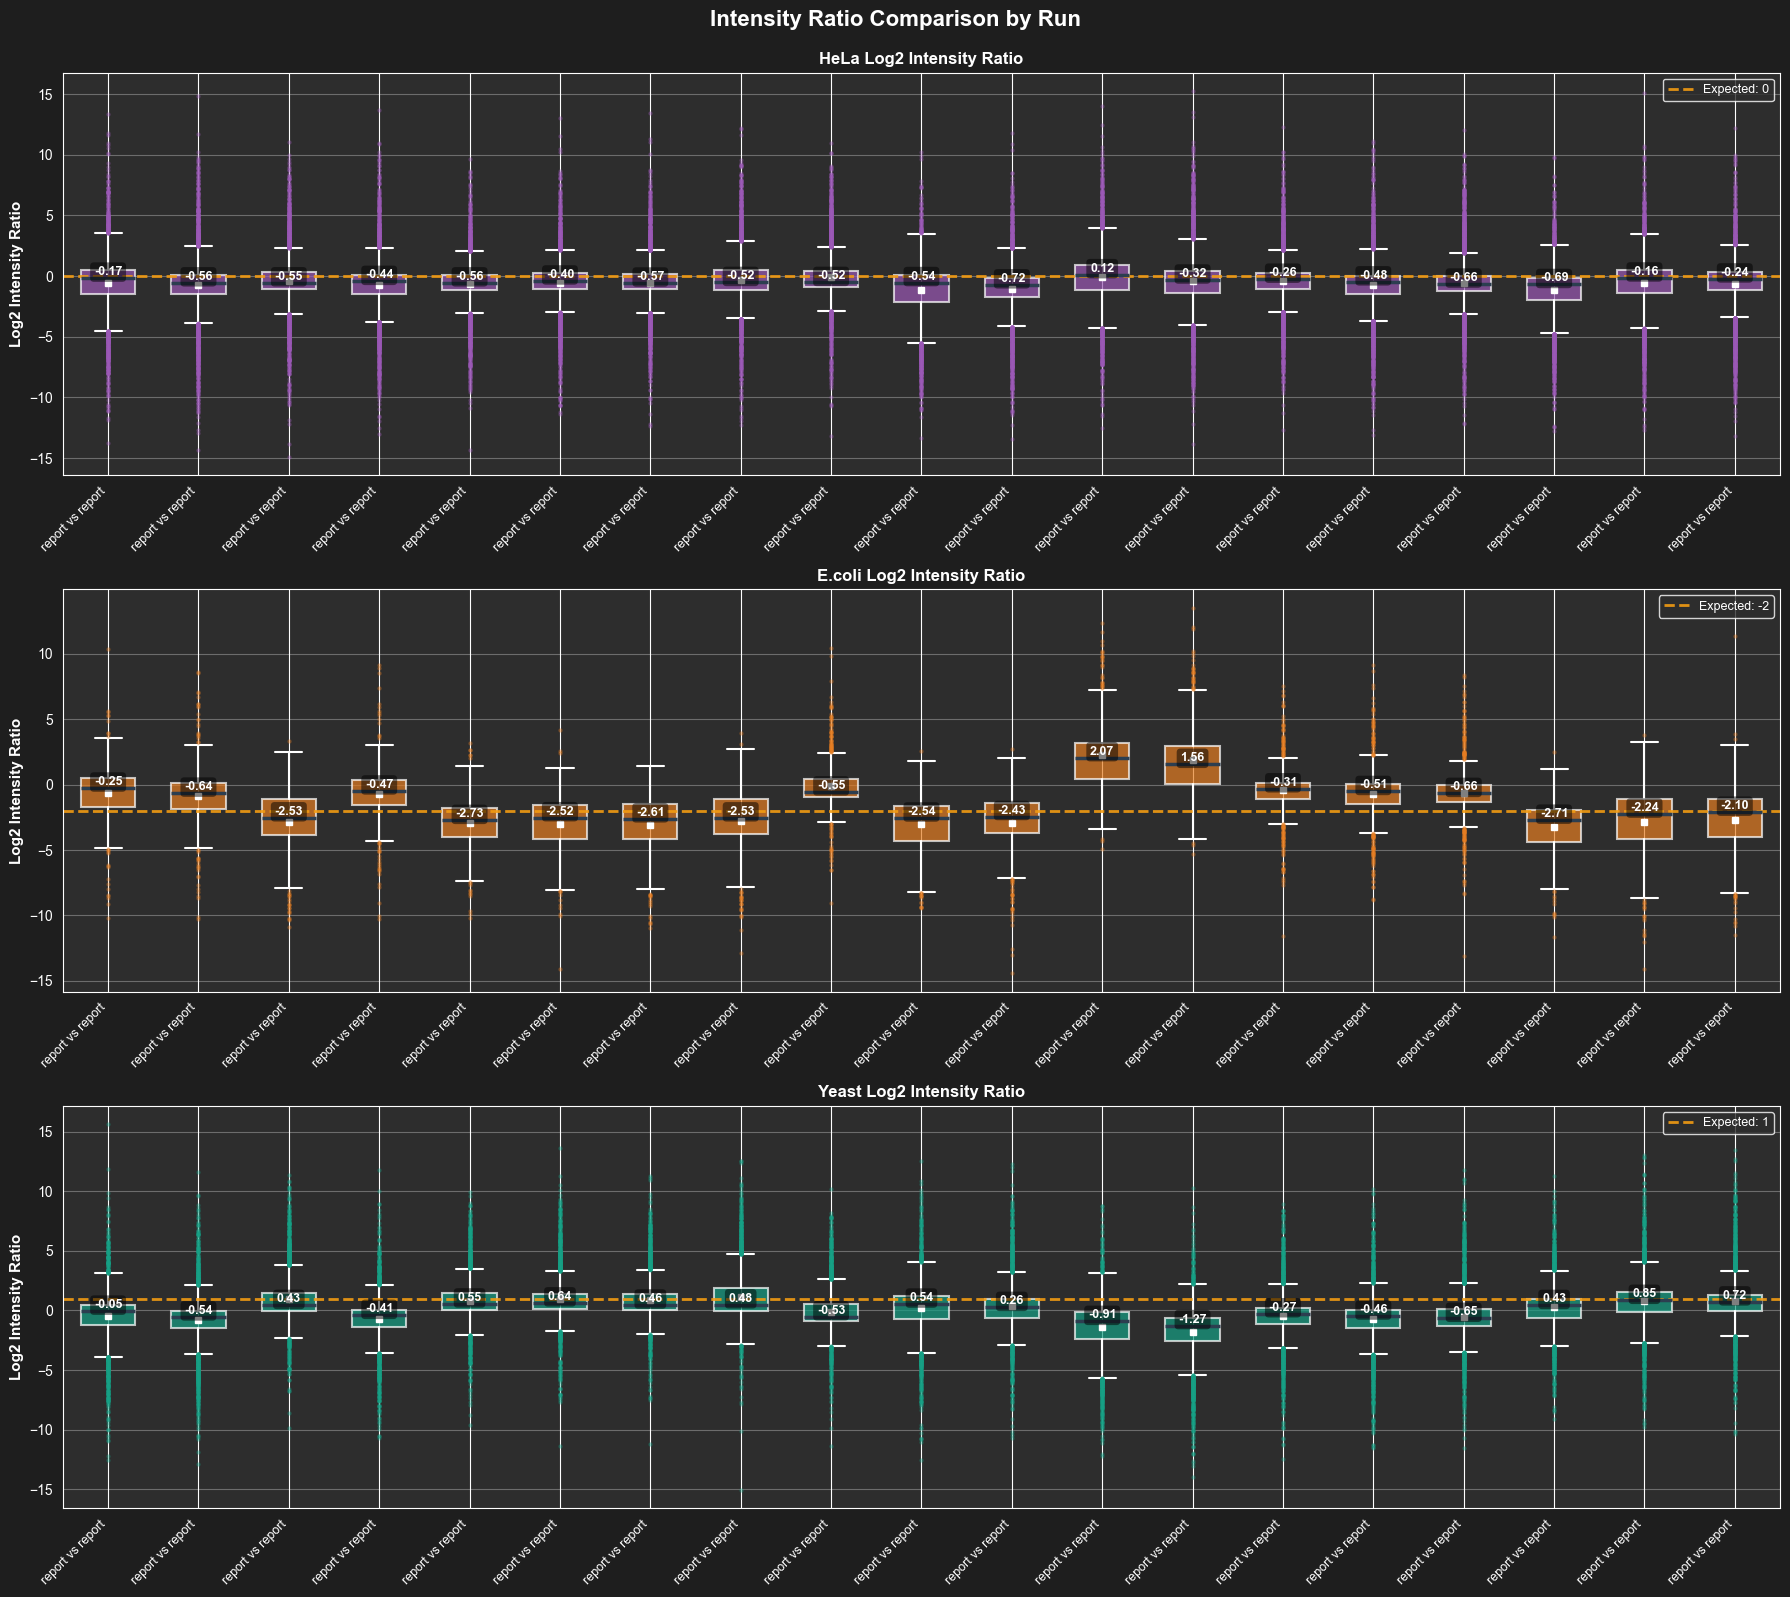


✓ Plots generated successfully


In [13]:
if hela_results or ecoli_results or yeast_results:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 16))

    if hela_results:
        plot_ratio_comparison(
            ax1, hela_results,
            title="HeLa Log2 Intensity Ratio",
            color="#9b59b6",
            reference_line=0
        )
    else:
        ax1.text(0.5, 0.5, "No HeLa data", ha="center", va="center",
                transform=ax1.transAxes, fontsize=14)
        ax1.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax1.set_title("HeLa Log2 Intensity Ratio", fontsize=12, fontweight="bold")

    if ecoli_results:
        plot_ratio_comparison(
            ax2, ecoli_results,
            title="E.coli Log2 Intensity Ratio",
            color="#e67e22",
            reference_line=-2
        )
    else:
        ax2.text(0.5, 0.5, "No E.coli data", ha="center", va="center",
                transform=ax2.transAxes, fontsize=14)
        ax2.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax2.set_title("E.coli Log2 Intensity Ratio", fontsize=12, fontweight="bold")

    if yeast_results:
        plot_ratio_comparison(
            ax3, yeast_results,
            title="Yeast Log2 Intensity Ratio",
            color="#16a085",
            reference_line=1
        )
    else:
        ax3.text(0.5, 0.5, "No Yeast data", ha="center", va="center",
                transform=ax3.transAxes, fontsize=14)
        ax3.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax3.set_title("Yeast Log2 Intensity Ratio", fontsize=12, fontweight="bold")

    plt.suptitle(
        "Intensity Ratio Comparison by Run",
        fontsize=16,
        fontweight="bold",
        y=0.995
    )
    plt.tight_layout()
    plt.show()

    print("\n✓ Plots generated successfully")
else:
    print("⚠ No results to plot - check that your data contains valid E25/E100 pairs")

## 11. Statistical Summaries

Calculate and display statistical summaries (count, median, mean, std, quartiles) for each organism's intensity ratios across all experimental runs.

In [14]:
# Calculate and display statistics for all organisms
def print_stats(results, organism_name):
    if results:
        print(f"{organism_name} Statistics:")
        print("=" * 60)
        for ratios, mix_id in results:
            print(f"\n{mix_id}:")
            print(f"  Count: {len(ratios)}")
            print(f"  Median: {np.median(ratios):.3f}")
            print(f"  Mean: {np.mean(ratios):.3f}")
            print(f"  Std: {np.std(ratios):.3f}")
            print(f"  Q1-Q3: {np.percentile(ratios, 25):.3f} - {np.percentile(ratios, 75):.3f}")
    else:
        print(f"No {organism_name} results")

print_stats(hela_results, "HeLa")
print("\n")
print_stats(ecoli_results, "E.coli")
print("\n")
print_stats(yeast_results, "Yeast")

HeLa Statistics:

report vs report:
  Count: 5133
  Median: -0.168
  Mean: -0.554
  Std: 2.360
  Q1-Q3: -1.507 - 0.513

report vs report:
  Count: 5286
  Median: -0.556
  Mean: -0.761
  Std: 2.419
  Q1-Q3: -1.498 - 0.099

report vs report:
  Count: 5380
  Median: -0.555
  Mean: -0.439
  Std: 2.106
  Q1-Q3: -1.050 - 0.308

report vs report:
  Count: 5112
  Median: -0.436
  Mean: -0.704
  Std: 2.252
  Q1-Q3: -1.462 - 0.065

report vs report:
  Count: 4865
  Median: -0.559
  Mean: -0.662
  Std: 1.913
  Q1-Q3: -1.158 - 0.125

report vs report:
  Count: 5107
  Median: -0.402
  Mean: -0.566
  Std: 1.994
  Q1-Q3: -1.057 - 0.227

report vs report:
  Count: 5067
  Median: -0.573
  Mean: -0.539
  Std: 1.959
  Q1-Q3: -1.094 - 0.191

report vs report:
  Count: 5187
  Median: -0.523
  Mean: -0.335
  Std: 2.216
  Q1-Q3: -1.110 - 0.481

report vs report:
  Count: 5505
  Median: -0.522
  Mean: -0.095
  Std: 1.965
  Q1-Q3: -0.885 - 0.438

report vs report:
  Count: 4937
  Median: -0.535
  Mean: -1.151


## 12. Validation Report

Validate that intensity ratios match expected patterns for each organism:
- **HeLa**: Expected ≈ 0 (constant concentration), PASS if |median| < 0.5
- **E.coli**: Expected ≈ -2 (4-fold reduction), PASS if -2.5 < median < -1.5  
- **Yeast**: Expected ≈ +1 (2-fold increase), PASS if 0.5 < median < 1.5

Results indicate whether sample preparation and instrument performance meet specifications.

In [15]:
print("Validation Summary:")
print("=" * 60)

if hela_results:
    hela_medians = [np.median(r[0]) for r in hela_results]

    print("\nHeLa Expected Pattern:")
    print(f"  Median range: {min(hela_medians):.2f} to {max(hela_medians):.2f}")
    print(f"  Average median: {np.mean(hela_medians):.2f}")
    print("  Expected: ~0 (constant concentration)")
    print(f"  Status: {'✓ PASS' if abs(np.mean(hela_medians)) < 0.5 else '⚠ CHECK'}")

if ecoli_results:
    ecoli_medians = [np.median(r[0]) for r in ecoli_results]

    print("\nE.coli Expected Pattern:")
    print(f"  Median range: {min(ecoli_medians):.2f} to {max(ecoli_medians):.2f}")
    print(f"  Average median: {np.mean(ecoli_medians):.2f}")
    print("  Expected: ~-2 (log2(25/100) = -2)")
    print(f"  Status: {'✓ PASS' if -2.5 < np.mean(ecoli_medians) < -1.5 else '⚠ CHECK'}")

if yeast_results:
    yeast_medians = [np.median(r[0]) for r in yeast_results]

    print("\nYeast Expected Pattern:")
    print(f"  Median range: {min(yeast_medians):.2f} to {max(yeast_medians):.2f}")
    print(f"  Average median: {np.mean(yeast_medians):.2f}")
    print("  Expected: ~+1 (log2(150/75) = 1)")
    print(f"  Status: {'✓ PASS' if 0.5 < np.mean(yeast_medians) < 1.5 else '⚠ CHECK'}")

print("\n✓ Analysis complete!")

Validation Summary:

HeLa Expected Pattern:
  Median range: -0.72 to 0.12
  Average median: -0.43
  Expected: ~0 (constant concentration)
  Status: ✓ PASS

E.coli Expected Pattern:
  Median range: -2.73 to 2.07
  Average median: -1.30
  Expected: ~-2 (log2(25/100) = -2)
  Status: ⚠ CHECK

Yeast Expected Pattern:
  Median range: -1.27 to 0.85
  Average median: 0.01
  Expected: ~+1 (log2(150/75) = 1)
  Status: ⚠ CHECK

✓ Analysis complete!


## Summary

This notebook provides a complete workflow for analyzing mass spectrometry proteomics data from the Orbitrap Astral using DIA-NN outputs:

### Part 1: Protein Quantification Analysis
1. **Import & Configure** (Section 1): Set up libraries and plotting styles
2. **Define Patterns** (Section 2): Establish organism identification rules
3. **Load Data** (Sections 3-4): Select and process TSV files
4. **Explore Data** (Section 5): View organism distribution and data summary
5. **Define Analysis Functions** (Section 6): Set up helper functions for ratio calculations
6. **Calculate Ratios** (Section 7): Compute E25/E100 intensity ratios using hybrid categorization
   - First tries explicit naming (E25/E100/Y150/Y75 patterns)
   - Falls back to E.coli median-based auto-categorization if needed
7. **Visualize** (Sections 8-10): Create protein counts and ratio distribution plots
8. **Analyze Statistics** (Section 11): Display median, mean, and quartile summaries
9. **Validate Results** (Section 12): Check if ratios match expected biological patterns

### Part 2: TIC Analysis (Optional)
10. **TIC Setup** (Section 13.1): Import pyteomics for mzML processing
11. **Load mzML Files** (Section 13.2): Select raw MS data files
12. **Extract TIC** (Section 13.3): Parse mzML and extract Total Ion Current
13. **Visualize TIC** (Section 13.4): Compare TIC traces across samples

**Expected Outcomes**: 
- Protein ratios should match theoretical predictions (HeLa≈0, E.coli≈-2, Yeast≈+1)
- TIC traces should show consistent peak shapes and intensities
- Results confirm proper sample preparation and instrument performance

**New Features**:
- **Smart Sample Categorization**: Automatic E25/E100 detection via E.coli median when filenames lack explicit patterns
- **Yeast Relationship Tracking**: Recognizes E25↔Y150 and E100↔Y75 equivalence
- **TIC Analysis**: Complementary QC using raw MS data (mzML files)

## 13. TIC Analysis (Optional)

**Total Ion Current (TIC)** analysis provides a complementary view of sample quality and instrument performance by visualizing the sum of all ion intensities across the chromatographic run.

**When to use TIC analysis:**
- Quality control of raw MS data before protein identification
- Detecting instrument drift or performance issues
- Comparing chromatographic reproducibility across runs
- Identifying sample loading or elution problems

**Note**: This section requires mzML files (raw MS data), which are separate from the TSV protein quantification files used above.

### 13.1 Import TIC Dependencies

Additional libraries needed for mzML processing:
- `pyteomics`: Proteomics data parsing library
- `lxml`: XML parsing (dependency for pyteomics)

In [16]:
try:
    from pyteomics import mzml
    print("✓ pyteomics imported successfully")
except ImportError:
    print("⚠ pyteomics not found. Installing required packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pyteomics", "lxml"])
    from pyteomics import mzml
    print("✓ pyteomics installed and imported")

✓ pyteomics imported successfully


### 13.2 Select mzML Files

Choose your mzML files for TIC analysis. These are the raw mass spectrometry data files, typically larger than the processed TSV files.

In [17]:
root = Tk()
root.withdraw()
root.attributes('-topmost', True)

print("Please select your mzML files for TIC analysis...")
mzml_file_paths = filedialog.askopenfilenames(
    title='Select mzML Files (you can select multiple)',
    filetypes=[('mzML files', '*.mzML'), ('All files', '*.*')]
)

if len(mzml_file_paths) == 0:
    print("⚠ No mzML files selected. Skipping TIC analysis.")
    mzml_file_paths = []
else:
    print(f"✓ Selected {len(mzml_file_paths)} mzML file(s):")
    for fp in mzml_file_paths:
        print(f"  - {Path(fp).name}")

Please select your mzML files for TIC analysis...
✓ Selected 2 mzML file(s):
  - HYE_E100_base_20251115092119_Q3.mzML
  - HYE_E100_base_20251115105239_Q3.mzML
✓ Selected 2 mzML file(s):
  - HYE_E100_base_20251115092119_Q3.mzML
  - HYE_E100_base_20251115105239_Q3.mzML


### 13.3 Extract TIC Data

Parse mzML files and extract Total Ion Current for each scan. 

**Processing notes:**
- DIA data: Processes all scans (no MS level filtering required)
- DDA data: Would filter for MS1 scans only
- Retention time: Auto-converts from seconds to minutes if needed
- This step may take 1-2 minutes per file depending on file size

In [18]:
def extract_tic_from_mzml(file_path):
    """Extract Total Ion Current (TIC) from an mzML file.

    For DIA data, processes all scans regardless of MS level.

    Args:
        file_path: Path to the mzML file

    Returns:
        pd.DataFrame with columns: scan_number, retention_time, tic
    """
    tic_data = []

    try:
        # Open mzML file and iterate through scans
        with mzml.read(file_path) as reader:
            for scan in reader:
                scan_number = scan.get('index', 0) + 1

                # Get retention time (in minutes or seconds)
                rt = scan.get('scanList', {}).get('scan', [{}])[0].get('scan start time', 0)

                # Calculate TIC from intensity array
                intensities = scan.get('intensity array', np.array([]))
                tic = np.sum(intensities) if len(intensities) > 0 else 0

                tic_data.append({
                    'scan_number': scan_number,
                    'retention_time': rt,
                    'tic': tic
                })

        if len(tic_data) == 0:
            print(f"  ⚠ No scans found in {Path(file_path).name}")
            return None

        df = pd.DataFrame(tic_data)

        # Auto-detect RT units and convert to minutes if needed
        max_rt = df['retention_time'].max()
        if max_rt > 500:  # Likely in seconds
            df['retention_time'] = df['retention_time'] / 60.0
            print(f"  ✓ Converted RT from seconds to minutes (max RT: {max_rt/60:.2f} min)")

        if df['retention_time'].max() > 600:
            print(f"  ⚠ Warning: Max RT is {df['retention_time'].max():.2f} minutes - seems unusually high")

        print(f"  ✓ Extracted {len(df)} scans, RT range: {df['retention_time'].min():.2f}-{df['retention_time'].max():.2f} min")
        return df

    except Exception as e:
        print(f"  ✗ Error processing {Path(file_path).name}: {e}")
        return None


# Extract TIC from all selected mzML files
tic_dict = {}

if len(mzml_file_paths) > 0:
    print("Extracting TIC data from mzML files...\n")
    for mzml_path in mzml_file_paths:
        sample_name = Path(mzml_path).stem
        print(f"Processing: {sample_name}")
        tic_df = extract_tic_from_mzml(mzml_path)
        if tic_df is not None:
            tic_dict[sample_name] = tic_df

    print(f"\n✓ Successfully extracted TIC from {len(tic_dict)}/{len(mzml_file_paths)} file(s)")
else:
    print("No mzML files to process")

Extracting TIC data from mzML files...

Processing: HYE_E100_base_20251115092119_Q3
  ✓ Converted RT from seconds to minutes (max RT: 29.82 min)
  ✓ Extracted 12106 scans, RT range: 0.07-29.82 min
Processing: HYE_E100_base_20251115105239_Q3
  ✓ Converted RT from seconds to minutes (max RT: 29.82 min)
  ✓ Extracted 12106 scans, RT range: 0.07-29.82 min
Processing: HYE_E100_base_20251115105239_Q3
  ✓ Converted RT from seconds to minutes (max RT: 29.83 min)
  ✓ Extracted 12145 scans, RT range: 0.13-29.83 min

✓ Successfully extracted TIC from 2/2 file(s)
  ✓ Converted RT from seconds to minutes (max RT: 29.83 min)
  ✓ Extracted 12145 scans, RT range: 0.13-29.83 min

✓ Successfully extracted TIC from 2/2 file(s)


### 13.4 Generate TIC Comparison Plot

Visualize TIC across retention time for all samples. The plot shows:
- **X-axis**: Retention time (minutes)
- **Y-axis**: Total Ion Current (sum of all ion intensities)
- **Lines**: One trace per sample file

**What to look for:**
- Consistent peak shapes indicate good reproducibility
- Similar total intensities suggest consistent sample loading
- Unusual dips or spikes may indicate instrument issues

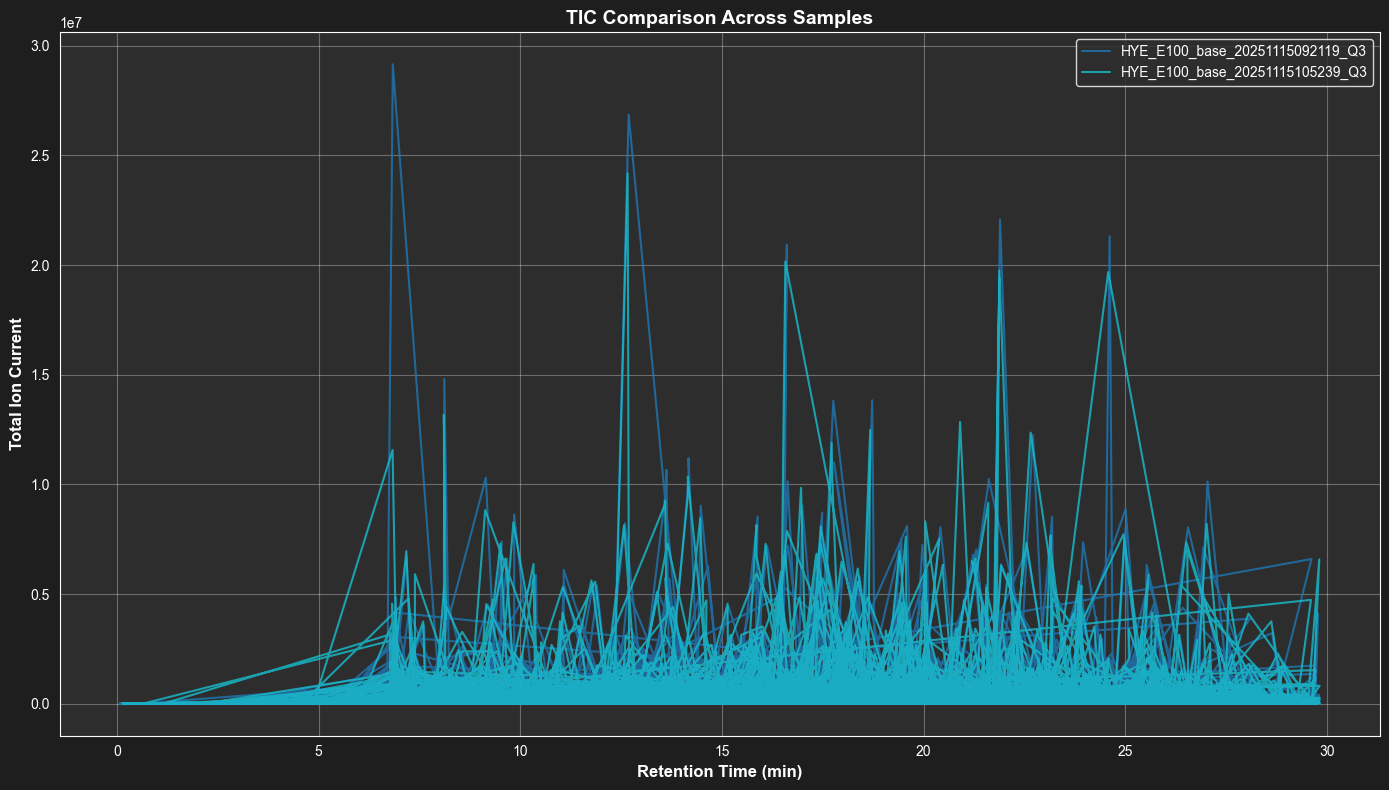


✓ TIC plot generated successfully


In [ ]:
if len(tic_dict) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Color palette for different samples
    colors = plt.colormaps['tab10'](np.linspace(0, 1, len(tic_dict)))

    for (sample_name, tic_df), color in zip(tic_dict.items(), colors, strict=True):
        if tic_df is not None and len(tic_df) > 0:
            ax.plot(
                tic_df['retention_time'],
                tic_df['tic'],
                label=sample_name,
                color=color,
                linewidth=1.5,
                alpha=0.8
            )

    ax.set_xlabel('Retention Time (min)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Total Ion Current', fontsize=12, fontweight='bold')
    ax.set_title('TIC Comparison Across Samples', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
    plt.tight_layout()
    plt.show()

    print("\n✓ TIC plot generated successfully")
else:
    print("⚠ No TIC data to plot. Run the previous cells to extract TIC data.")